# Building a language model

Here we'll be loading the cleaned text and doing some statistical analysis. Afterwards, we will build a set of word vectors from the cleaned corpus.

In [1]:
import os, re
import pickle
import warnings
import itertools as it
from collections import Counter
import umap as UMAP
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
from_scratch = True

In [4]:
nupepa_sents_file = "../data/niupepa.txt"
with open(nupepa_sents_file, "r", encoding = 'utf-8') as f:
    nupepa_sents = f.read().strip().split("\n")

In [6]:
nupepa_sents[:5]

["hoʻolaupaʻi he ʻohina nūpepa ʻōlelo hawaiʻi hoʻolaupaʻi he ʻohina nūpepa ʻōlelo hawaiʻi hoʻolaupaʻi he ʻohina nūpepa ʻōlelo hawaiʻi kōkua kekahi kōkua kekahi kekahi helu kekemapa ʻaoʻao ka moana a holo mai la e una o ka moku -e aole e lilo ana ia komo ana i iloko o keia^aoao i mea e '-a aku ai lakou he poe eka e nana mua ia aku ana ko kupaa mahope o ko lakou aoao iea hou mamua o ka noonoo- i aku o ko lakou mau make- e o ka haawiia aku i na i noho pouliuli na alakai o ka i ke kulana o ka -a o ke aupuni kuianakauhale makahiki lehulehu ae nei i o ia ao ke kaa holookoa ana '^a lawelawe ana i na oihana ^e aupuni i na 'ka oihana makai ke kulana ",
 'i ',
 'keena o ka loio kalana ke keena o ka enekinia kalana ame kona mau lala lehulehu e laa na kahua paani ame na paka ame na halekula ame kekahi mau hana e ae i puunauweia aku iwaena o na i komo iloko o ka hooikaika kalaiaina ana no ka lanakila o na moho ',
 'me kela ike i loaa ia lakou no ka manawa no nei i hala pela ao i paa ioa ai ko lakou

## N-grams

In [7]:
from nltk import ngrams
from nltk import word_tokenize

In [8]:
list(ngrams(word_tokenize("Hello there my friend"), 3))

[('Hello', 'there', 'my'), ('there', 'my', 'friend')]

In [9]:
warnings.filterwarnings('ignore')
ngram_length = 4
ngram_list = []
for text in nupepa_sents:
    sent = word_tokenize(text)
    for ngram in ngrams(sent, ngram_length):
        ngram_list.append(ngram)

## Stop words

In [11]:
def plot_word_frequencies(filepath, pattern='', num_terms=20, 
                          stop_words = [], title = ''):
    '''
    Plot the top `num_terms` words from the file at `filepath` matching `pattern`.
    Can also set the `title` as well.
    '''
    with open(filepath, "r") as f:
        file_sents = f.read().strip().split("\n")
    kupu = [kupu for sent in file_sents \
                 for kupu in sent.split(" ") \
                 if (len(pattern) == 0 or re.match(pattern, kupu)) and\
                 not kupu in stop_words]
    return (
        pd.Series(kupu)
            .value_counts()
            .head(num_terms)
            .sort_values()
            .plot(kind = 'barh', title = title))`

In [12]:
plot_word_frequencies('../data/trigram_sentences_all.txt', stop_words = [], num_terms=20)

FileNotFoundError: [Errno 2] No such file or directory: '../data/trigram_sentences_all.txt'

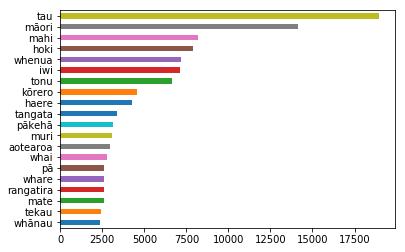

In [10]:
plot_word_frequencies('../data/trigram_sentences_all.txt', num_terms=20)

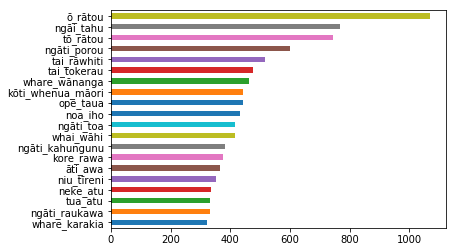

In [11]:
plot_word_frequencies('../data/trigram_sentences_all.txt', pattern="[^_]+_[^_]+_?[^_]*")

## Gensim

We will use the `gensim` library to analyse the text further.

In [29]:
from gensim.models.phrases import Phrases
from gensim.models.word2vec import LineSentence

In [30]:
unigram_sentences = LineSentence(nupepa_sents_file)

In [31]:
for unigram_sentence in it.islice(unigram_sentences, 230, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

la ua make hikiwawe oa lakou ma ka hoomaopopo iho a na makai

la

o ke emi loa he mau kanaka he o ia heluna he mau keiki i make i keia la iloko o ka manawa e pa ana ka makani ikaika a hiolo ka hale- kula maanei ame kekahi mau hale e aku

he elua mau mea i make ma ka manawa e laweia aku ana laua no ka halema i

ma kahi o mau keiki maloko o ka halekula ma ka manawa i hiolo ai

hopuia o no ke peku ana i ka u-ha no kekahi mau kumu hoomauha- la i maopopo ole he elua mau kumu- hoopii e ku-e ana ia i hookomoia ae i ka aha a paa ae oia i ka hopuia no ka hoeha ame ka hoeha me ka mea eha ku i ka make ma ka auwina la o ka poaono ka pule aku la i hala o ua hoike ka mea nona ka halekuai mea ma ke alanui nuuanu ame o waikiki

o ka makai kalima ka mea nana hopu ia a ma kana hoike o ke kumu o ka hoeha ana o ia penei ia ma ka olelo iaia ua komo aku iloko o kana hale- kuai a hoomaka aku la ka hoohaka- ka ana iaia

ua pekuia o ma ka u-ha akau me ka hoo- puka pu ana aku i kekahi mau hua- olelo hailiili in

In [32]:
bigram_model_filepath = '../models/te_ara_bigrams.model'

if from_scratch or not os.path.exists(bigram_model_filepath):

    bigram_model = Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    
else:
    # load the finished model from disk
    bigram_model = Phrases.load(bigram_model_filepath)

In [33]:
bigram_sentences_filepath = '../data/bigram_sentences_all.txt'
if from_scratch or not os.path.exists(bigram_sentences_filepath):
    
    with open(bigram_sentences_filepath, 'w', encoding = 'utf-8') as f:    
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')

In [34]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [35]:
trigram_model_filepath = '../models/te_ara_trigrams.model'
trigram_sentences_filepath = '../data/trigram_sentences_all.txt'

In [36]:
if from_scratch or not os.path.exists(trigram_model_filepath):
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
else:
    # load the finished model from disk
    trigram_model = Phrases.load(trigram_model_filepath)

In [37]:
for bigram_sentence in it.islice(bigram_sentences, 230, 240):
    print(' '.join(bigram_sentence))

la ua make hikiwawe oa lakou ma ka hoomaopopo iho a na makai
la
o ke emi loa he mau kanaka he o ia heluna he mau keiki i make i keia la iloko o ka manawa e pa ana ka makani ikaika a hiolo ka hale- kula maanei ame kekahi mau hale e aku
he elua mau mea i make ma ka manawa e laweia aku ana laua no ka halema i
ma kahi o mau keiki maloko o ka halekula ma ka manawa i hiolo ai
hopuia o no ke peku ana i ka u-ha no kekahi mau kumu hoomauha- la i maopopo ole he elua mau kumu-_hoopii e ku-e ana ia i hookomoia ae i ka aha a paa ae oia i ka hopuia no ka hoeha ame ka hoeha me ka mea eha ku i ka make ma ka auwina la o ka poaono ka pule aku la i hala o ua hoike ka mea nona ka halekuai mea ma ke alanui_nuuanu ame o waikiki
o ka makai kalima ka mea nana hopu ia a ma kana hoike o ke kumu o ka hoeha ana o ia penei ia ma ka olelo iaia ua komo aku iloko o kana hale- kuai a hoomaka aku la ka hoohaka- ka ana iaia
ua pekuia o ma ka u-ha_akau me ka hoo- puka pu ana aku i kekahi mau hua- olelo hailiili ino iaia


In [39]:
if from_scratch or not os.path.exists(trigram_sentences_filepath):
    with open(trigram_sentences_filepath, 'w', encoding = 'utf-8') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')

In [40]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [41]:
for trigram_sentence in it.islice(trigram_sentences, 320, 330):
    print(' '.join(trigram_sentence))
    print('')

ae ai ia ia manawa e maopopo loa ai ka huina pokole maoli

no ka hooiaio aua nae i ka pololei o na mea i loaa iaia ma kela poaha ua hooia hou o ma kekahi alahele okoa mai a o ka mea i loaa iaia aia he like ole o kanakolu-ku-_mamalima mai ka huina mua mai i loaa iaia ma ka poaha aku

mahope iho o ka hoopuka ana ae o ke nieniele_kumu_make i kana olelo_hooholo no ke kumu o ka make ana o mamuli no ia o na palapu i loaa iaia ma ka ulia kaa i paa ae ai o hookano o papakolea i ka hopuia e ka hope makai nui ma ke kakahiaka o ka poalua iho nei malalo o ke kumu hoopii laweola

e hoakaka ana ka olelo_hooholo a kela o ke kumu o ka loaa ana o ka ulia i ukali aku ai ka make mahope o o ia no ka holonui me ka hooponopono ole o hookano i kona kaa

ma ka moolelo o kela ulia i wai-_hoia ae imua o ke nieniele_kumu_make e kau ana o hookano ame kauai maluna o kekahi kaa a o hookano ka mea nana e hookele ana

iloko o ka holonui o ke kaa ua hooku i aku la ia iahope o ke kaa e hookeleia ana e ma ke alanui_nuua

# Modelling with LDA

Now we can use Latent Dirichlet Allocation (LDA) to train a topic model.

In [43]:
! pip3 install pyLDAvis

    100% |################################| 1.6MB 806kB/s 
    100% |################################| 829kB 1.7MB/s 
    100% |################################| 163kB 8.3MB/s 
    100% |################################| 225kB 5.6MB/s 
    100% |################################| 92kB 13.9MB/s 
    100% |################################| 61kB 13.0MB/s 
  Running setup.py bdist_wheel for pyLDAvis ... done
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /root/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built pyLDAvis future


In [44]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import warnings

In [45]:
trigram_dictionary_filepath = '../data/nupepa_trigrams.dict'
trigram_bow_filepath = '../models/nupepa_trigram_bow_corpus.model'

In [47]:
%%time
if from_scratch or not os.path.exists(trigram_dictionary_filepath):

    trigram_reviews = [[kupu for kupu in sent] \
                             for sent in LineSentence(trigram_sentences_filepath)]

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)

else:
    # load the finished dictionary from disk
    trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

CPU times: user 6.21 s, sys: 68.1 ms, total: 6.28 s
Wall time: 6.26 s


In [48]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for line in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(line)

In [57]:
if from_scratch or not os.path.exists(trigram_bow_filepath):

    # generate bag-of-words representations for
    # all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_sentences_filepath))

# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

In [58]:
lda_model_filepath = '../models/nupepa_model.lda'

In [60]:
if from_scratch or not os.path.exists(lda_model_filepath):

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=100,
                           id2word=trigram_dictionary,
                           workers=cpu_count() - 1)
    
    lda.save(lda_model_filepath)
else:
    # load the finished LDA model from disk
    lda = LdaMulticore.load(lda_model_filepath)

In [61]:
def explore_topic(topic_number, topn=10):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print('{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=topn):
        print('{:20} {:.3f}'.format(term, round(frequency, 3)))

In [69]:
for i in range(10):
    print("Topic:", i + 1)
    explore_topic(i)
    print()

Topic: 1
term                 frequency

na                   0.046
me                   0.030
ia                   0.029
ana                  0.029
kipi                 0.029
ma                   0.027
ua                   0.026
no                   0.025
lakou                0.024
la                   0.024

Topic: 2
term                 frequency

ana                  0.059
no                   0.043
na                   0.040
me                   0.031
ua                   0.027
ia                   0.018
la                   0.018
ae                   0.018
ma                   0.016
keia                 0.015

Topic: 3
term                 frequency

ia                   0.041
no                   0.040
mea                  0.039
aole                 0.038
me                   0.033
ua                   0.030
he                   0.029
loa                  0.026
nui                  0.025
keia                 0.025

Topic: 4
term                 frequency

ia                   0.

In [70]:
LDAvis_data_filepath = '../models/prepared_model.ldavis'

In [72]:
if from_scratch or not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, trigram_dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

In [73]:
pyLDAvis.display(LDAvis_prepared)

## Training word vectors

Here I'll train some word vectors based on the Te Ara Corpus.

In [76]:
from gensim.models import Word2Vec

trigram_sentences = LineSentence(trigram_sentences_filepath)
word2vec_filepath = '../models/nupepa_word2vec.model'

In [77]:
def count_sentences(line_sentence):
    line_count = 0
    for line in line_sentence:
        line_count += 1
    return line_count

In [78]:
if from_scratch or not os.path.exists(word2vec_filepath):

    # initiate the model and perform the first epoch of training
    olelo2vec = Word2Vec(trigram_sentences, size=100, window=5,
                        min_count=20, sg=1, workers=cpu_count()-1)

    # perform 10 epochs of training
    olelo2vec.train(
        trigram_sentences,
        total_examples = count_sentences(trigram_sentences), 
        epochs = 10)

    olelo2vec.save(word2vec_filepath)
else:
    # load the finished model from disk
    olelo2vec = Word2Vec.load(word2vec_filepath)
    olelo2vec.init_sims()

In [79]:
olelo2vec.wv.most_similar("aloha")

[('welina', 0.6140680313110352),
 ('kuahine', 0.5903775095939636),
 ("hoa'loha", 0.5884342193603516),
 ('paumako', 0.5816829800605774),
 ('walohia', 0.5696635842323303),
 ('uwe', 0.5671802759170532),
 ('kuu', 0.5635972619056702),
 ('auwe_kuu', 0.5546947121620178),
 ('minamina', 0.5482827425003052),
 ('pumehana', 0.5471652746200562)]

# Visualising the word vectors

Now that we've trained a collection of word vectors, we can visualise them with the common dimensionality reduction algorithms.

In [80]:
from sklearn.manifold import TSNE

In [81]:
# build a list of the terms, integer indices,
# and term counts from the food2vec model vocabulary
ordered_vocab = [(term, olelo2vec.wv.vocab[term].index, olelo2vec.wv.vocab[term].count)
                 for term in olelo2vec.wv.vocab]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda vocab: -vocab[-1])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(olelo2vec.wv.vectors_norm[term_indices, :],
                            index=ordered_terms)

word_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ka,-0.016492,-0.230779,-0.081128,-0.180859,-0.037540,-0.120011,0.035569,0.271491,-0.066694,-0.190360,...,-0.099010,0.236320,0.101286,0.129518,-0.017123,0.095188,-0.066766,-0.074246,-0.166213,0.021555
i,-0.009479,-0.175612,-0.070193,-0.117273,-0.050080,-0.077586,0.014303,0.264070,-0.109367,-0.145331,...,-0.069081,0.154445,0.111896,0.076621,0.065982,0.013299,-0.052172,0.143160,-0.013606,0.119216
o,0.145821,-0.145276,-0.032332,-0.126095,0.014039,-0.055440,-0.030488,0.178679,-0.007303,-0.220910,...,-0.138738,0.150682,0.204926,0.052479,0.114032,0.057423,0.028754,0.100686,-0.003607,0.008832
a,-0.038494,-0.139244,-0.106606,-0.154486,-0.016390,-0.093383,0.048004,0.196791,-0.073291,-0.131453,...,-0.041403,0.246217,0.200153,0.094768,0.089367,0.050752,-0.019271,0.086838,-0.126983,0.025466
e,-0.040761,-0.217902,-0.029789,-0.174015,-0.013082,-0.060917,0.083354,0.250324,-0.073588,-0.122980,...,-0.051638,0.277797,0.064633,0.091827,0.073279,0.034377,-0.029352,0.051180,-0.116146,0.022760


In [82]:
dist_matrix = pd.DataFrame(
    np.matmul(word_vectors.values, word_vectors.values.transpose()),
    columns=word_vectors.index, index = word_vectors.index)

In [83]:
dist_matrix['word'] = dist_matrix.index
dist_matrix = dist_matrix.reset_index(drop=True)
dist_matrix = dist_matrix[['word'] + list(dist_matrix.columns)[:-1]]

In [84]:
dist_matrix.to_csv("../data/dist_matrix.csv", index = False)

In [85]:
dist_matrix.head()

,word,ka,i,o,a,e,na,ke,no,ana,...,lamaku,papa_kalakala,pahu_kupapau_maikai,paaua_hookahi,kanaka-auwana,oili_elua_puka'na,puali_puhiohe_lahui,hihio_ilihia,nanea_walohia,auki
0,ka,1.000000,0.686215,0.702592,0.733737,0.619410,0.637034,0.503087,0.605010,0.567914,...,0.092995,0.189435,0.280933,0.159868,0.117921,0.154726,0.072014,0.093470,0.252417,0.060121
1,i,0.686215,1.000000,0.678754,0.781126,0.811981,0.593523,0.567422,0.743452,0.659842,...,0.214926,0.196217,0.247976,0.152816,0.135953,0.148868,0.185606,0.144618,0.172161,0.131096
2,o,0.702592,0.678754,1.000000,0.716692,0.578734,0.553791,0.576273,0.559837,0.569910,...,0.322446,0.204644,0.255404,0.106145,0.101876,0.175741,0.221997,0.029039,0.238312,0.076443
3,a,0.733737,0.781126,0.716692,1.000000,0.703199,0.698373,0.592689,0.694927,0.702873,...,0.203951,0.220765,0.299443,0.133136,0.093164,0.069741,0.156756,0.106392,0.165512,0.143510
4,e,0.619410,0.811981,0.578734,0.703199,1.000000,0.569306,0.565509,0.589211,0.683557,...,0.118956,0.101365,0.224162,0.179753,0.088090,0.076143,0.192872,0.094731,0.165117,0.139316


## Word counts

We can quickly assemble some word counts here to use later:

In [86]:
nga_kupu = []
for sent in trigram_sentences:
    for kupu in sent:
        nga_kupu.append(kupu)

In [87]:
word_counts = (pd.Series(nga_kupu)
     .value_counts()
     .pipe(pd.DataFrame)
     .reset_index()
)

word_counts.columns = ['word', 'word_count']

In [88]:
word_counts.head()

,word,word_count
0,ka,291076
1,i,230892
2,o,224662
3,a,144110
4,e,127294


## TSNE

In [89]:
tsne_filepath = '../models/nupepa_tsne.model'
tsne_vectors_filepath = '../models/tsne_vectors.npy'

In [90]:
if from_scratch or not os.path.exists(tsne_filepath) or not os.path.exists(tsne_vectors_filepath):
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(dist_matrix.drop('word', 1).values)
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)

else:
    with open(tsne_filepath, 'rb') as f:
        tsne = pickle.load(f)
        tsne_vectors = pd.np.load(tsne_vectors_filepath)

In [91]:
tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(dist_matrix.word),
                            columns=[u'x_coord', u'y_coord'])

In [96]:
tsne_vectors['word'] = tsne_vectors.index

tsne_vectors = tsne_vectors.reset_index(drop=True)

tsne_vectors = tsne_vectors.merge(word_counts, how = 'left', on = ['word'])

tsne_vectors = tsne_vectors[['word', 'x_coord', 'y_coord', 'word_count']]

In [98]:
tsne_vectors.to_csv("../data/tsne.csv", index = False)

In [97]:
tsne_vectors.head()

,word,x_coord,y_coord,word_count
0,ka,38.689342,-9.982628,291076
1,i,37.412304,-10.677072,230892
2,o,38.615849,-10.455295,224662
3,a,38.121826,-10.935897,144110
4,e,36.563210,-10.292625,127294


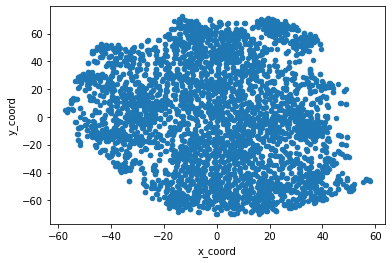

In [99]:
tsne_vectors.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord')

In [100]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.io.export import file_html

output_notebook()

Loading BokehJS ...

In [101]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

# UMAP clustering

In [102]:
umap_filepath = '../models/nupepa_umap.model'
umap_vectors_filepath = '../models/umap_vectors.npy'

In [105]:
if from_scratch or not os.path.exists(umap_filepath):
    
    umap = umap()
    umap_vectors = umap.fit_transform(dist_matrix.values)
    
    with open(umap_filepath, 'wb') as f:
        pickle.dump(umap, f)

    pd.np.save(umap_vectors_filepath, umap_vectors)

else:
    with open(umap_filepath, 'rb') as f:
        tsne = pickle.load(f)

umap_vectors = pd.np.load(umap_vectors_filepath)

umap_vectors = pd.DataFrame(umap_vectors,
                            index=pd.Index(dist_matrix.index),
                            columns=[u'x_coord', u'y_coord'])

umap_vectors['word'] = umap_vectors.index

NameError: name 'umap' is not defined

In [61]:
umap_vectors.reset_index(drop=True).to_csv("../data/umap.csv", index = False)

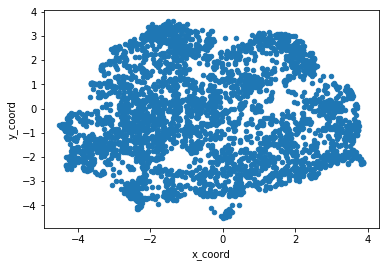

In [62]:
umap_vectors.plot(kind = 'scatter', x = 'x_coord', y = 'y_coord')

In [63]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(umap_vectors)

# create the plot and configure the
# title, dimensions, and tools
umap_plot = figure(title=u'UMAP Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
umap_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
umap_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
umap_plot.title.text_font_size = value(u'16pt')
umap_plot.xaxis.visible = False
umap_plot.yaxis.visible = False
umap_plot.grid.grid_line_color = None
umap_plot.outline_line_color = None

# engage!
show(umap_plot);